In [1]:
from IPython.display import Image
from IPython.core.display import HTML 


# Activate autocomplete
%config Completer.use_jedi = False

# Use the button below to toggle warnings
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

# TOC
- [Project description](#Project-description)
- [General description of the technological Process](#General-description-of-the-technological-Process)
- [Data description](#Data-description)
- [1. Data Inspection and preprocessing](#1.-Data-Inspection-and-preprocessing)
    * [1.1. Check recovery calculation flotation](#1.1.-Check-recovery-calculation-flotation)
    * [1.2. Missing features in the testset](#1.2.-Missing-features-in-the-testset)
    * [1.3. Data preprocessing](#1.3.-Data-preprocessing)
        + [1.3.1. Inspecting date columns of dataframes](#1.3.1.-Inspecting-date-columns-of-dataframes)
        + [1.3.2. Converting to datetime](#1.3.2.-Converting-to-datetime)
            - [1.3.2.1. Fixing datetime distortion in full df](#1.3.2.1.-Fixing-datetime-distortion-in-full-df)
            - [1.3.2.2. Fixing datetime distortion in train df](#1.3.2.2.-Fixing-datetime-distortion-in-train-df)
            - [1.3.2.3. Fixing datetime distortion in test df](#1.3.2.3.-Fixing-datetime-distortion-in-test-df)
        + [1.3.3. Setting the time as index](#1.3.3.-Setting-the-time-as-index)
        + [1.3.4. Filling missing / 0 values](#1.3.4.-Filling-missing-/-0-values)
        + [1.3.5. Adding targets to test dataset](#1.3.5.-Adding-targets-to-test-dataset)
- [2. Analyzing the data](#2.-Analyzing-the-data)
    * [2.1. Metal concentration over purification stages](#2.1.-Metal-concentration-over-purification-stages)
    * [2.2. Particle size distribution of test and train set](#2.2.-Particle-size-distribution-of-test-and-train-set)
    * [2.3. Substances through purification stages](#2.3.-Substances-through-purification-stages)
- [3. Build the model](#3.-Build-the-model)
    * [3.1. Write a function to calculate the final sMAPE value.](#3.1.-Write-a-function-to-calculate-the-final-sMAPE-value.)
    * [3.2. Preparing the dataframe, slicing features and targets](#3.2.-Preparing-the-dataframe,-slicing-features-and-targets)
        + [3.2.1. Dropping features](#3.2.1.-Dropping-features)
        + [3.2.2. Seperating dataframe](#3.2.2.-Seperating-dataframe)
        + [3.2.3. Train and Test split for dataframes](#3.2.3.-Train-and-Test-split-for-dataframes)
            - [3.2.3.1. With seperated dataframes](#3.2.3.1.-With-seperated-dataframes)
            - [3.2.3.2. With one dataframe](#3.2.3.2.-With-one-dataframe)
    * [3.3. Train different models](#3.3.-Train-different-models)
        + [3.3.1. Model evaluation rougher](#3.3.1.-Model-evaluation-rougher)
            - [3.3.1.1. Separated dataframes](#3.3.1.1.-Separated-dataframes)
            - [3.3.1.2. Combined dataframe](#3.3.1.2.-Combined-dataframe)
        + [3.3.2 Model evaluation cleaner](#3.3.2-Model-evaluation-cleaner)
            - [3.3.2.1. Separated dataframes](#3.3.2.1.-Separated-dataframes)
            - [3.3.2.2.. Combined dataframes](#3.3.2.2..-Combined-dataframes)
    * [3.4. Final evaluation](#3.4.-Final-evaluation)
        + [3.4.1. Rougher](#3.4.1.-Rougher)
        + [3.4.2. Flotation](#3.4.2.-Flotation)
        + [3.4.3. Combined](#3.4.3.-Combined)
- [4. Coclusion](#4.-Coclusion)

# Project description
Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.  
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.  
The model will help to optimize the production and eliminate unprofitable parameters.  
Therefore in this project the following steps have to be carried out:
- Prepare the data;  
- Perform data analysis;  
- Develop and train a model.  

# General description of the technological Process
Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.

In [2]:
Image(url= "https://pictures.s3.yandex.net/resources/ore_1591699963.jpg", width=800)

# Data description
**Technological process**
> - Rougher feed — raw material  
> - Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant  
> - Xanthate — promoter or flotation activator;  
> - Sulphate — sodium sulphide for this particular process;  
> - Depressant — sodium silicate.  
> - Rougher process — flotation  
> - Rougher tails — product residues  
> - Float banks — flotation unit  
> - Cleaner process — purification  
> - Rougher Au — rougher gold concentrate  
> - Final Au — final gold concentrate  
> - Parameters of stages  
> - air amount — volume of air  
> - fluid levels  
> - feed size — feed particle size  
> - feed rate  

**Feature naming**   
> - [stage].[parameter_type].[parameter_name]  
> - Example: rougher.input.feed_ag  
> - Possible values for [stage]:  
> - rougher — flotation  
> - primary_cleaner — primary purification  
> - secondary_cleaner — secondary purification  
> - final — final characteristics  
> - Possible values for [parameter_type]:  
> - input — raw material parameters  
> - output — product parameters  
> - state — parameters characterizing the current state of the stage  
> - calculation — calculation characteristics  

In [3]:
import warnings
from collections import defaultdict

# Data manipulating and plotting imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
import seaborn as sns
%matplotlib inline

# ML import

warnings.filterwarnings("ignore")  
# Scaling
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Cross valid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
import joblib
    
    
# Constants
RANDOM_STATE = 42
METALS = ['ag', 'au', 'pb']

try:
    df_train = pd.read_csv('./datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('./datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('./datasets/gold_recovery_full.csv')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


# 1. Data Inspection and preprocessing
> In this step the data has been prepared for analyzing as well as for training the machine learning model

## 1.1. Check recovery calculation flotation
> In this step the recovery for the rougher.output.recovery of the training dataset has been calculated in order to check if the calculation is correct and the measurement of the data within the plant works correctly. 
> Therefore the the calculation depicted below has been used

In [5]:
Image(url= "https://pictures.s3.yandex.net/resources/Recovery_1576238822_1589899219.jpg", width=500)

**With**
> - **C** — share of gold in the concentrate right after flotation
> - **F** — share of gold in the feed before flotation 
> - **T** — share of gold in the rougher tails right after flotation

> For this calculation first the rows with NaN values as well as the rows which lead to (-)inf values must be excluded from the calculation beacuse with them a calculation of the MAE is not possible.  
> Those cases are (because 0 in denominator):
> - F = 0
> - (C-T) = 0 


In [6]:
# Checking for the count of  previous mentioned invalid rows
((df_train['rougher.input.feed_au'] == 0) | ((df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']) == 0)).sum()

1159

In [7]:
df_train[df_train['rougher.input.feed_au'] == 0]['rougher.output.recovery']

99      NaN
100     NaN
101     NaN
102     NaN
103     NaN
         ..
12052   NaN
12053   NaN
12054   NaN
12055   NaN
12056   NaN
Name: rougher.output.recovery, Length: 1159, dtype: float64

> **Observation:**
> - All values which have eg C=0 as parameter have NaN values in the dataset anyway, this eases the slicing of the data for the caluclation in the next step

In [8]:
# Creating mask for comparable recoveries
mask_val = df_train[(df_train['rougher.output.concentrate_au'].isna() == False) & \
                    (df_train['rougher.input.feed_au'].isna() == False) & \
                    (df_train['rougher.output.tail_au'].isna() == False) & \
                    (df_train['rougher.output.recovery'].isna() == False) & \
                    (df_train['rougher.output.concentrate_au'] > 0) & \
                    (df_train['rougher.output.concentrate_au'] != \
                        df_train['rougher.output.tail_au']) & \
                    (df_train['rougher.input.feed_au'] > 0)
                   ].index

# Slicing crucial parameter
C = df_train.loc[mask_val, 'rougher.output.concentrate_au']
F = df_train.loc[mask_val, 'rougher.input.feed_au']
T = df_train.loc[mask_val, 'rougher.output.tail_au']
R_rough_df = df_train.loc[mask_val, 'rougher.output.recovery']

In [9]:
# Investigating if there are any NaN values 
pd.DataFrame.from_dict({'C': C, 'F': F,'T': T}).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13967 entries, 0 to 16859
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C       13967 non-null  float64
 1   F       13967 non-null  float64
 2   T       13967 non-null  float64
dtypes: float64(3)
memory usage: 436.5 KB


In [10]:
# Calculating recovery and calculating MAE
R_roug_calc = ((C * (F - T)) / (F * (C- T))) * 100
mae_r_rough = mean_absolute_error(R_rough_df, R_roug_calc)
print('The MAE for the floatation process is {:.2e}'.format(mae_r_rough))

The MAE for the floatation process is 9.52e-15


> **Observations:**
> - A MAE of round about 9.52e-15 is very low, so the formula is quite accurate for the flotation process


## 1.2. Missing features in the testset
> In this tep the previous detected missing valus have been investigated. 

In [11]:
# Investigating the missing collumns in the testset compared to train set
train_cols = set(df_test.columns)
diff = [col for col in df_train.columns if col not in train_cols]
df_dif = df_train.loc[:,diff]
df_dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                                16794 non-null  float64


> **Observations:**  
> - The missing features in the test set are the outputs of the steps rougher, primary and secondary cleaner as well as the final outputs for the concentrate and the tail.  
> Furthermore the recovery as well as the rougher calculations are not includet in the test set.
> - All the missing features are float values

## 1.3. Data preprocessing
> Due to the fact that some parameters are not available because they were measured and/or calculated much later in the maunfacturing process. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

> The abscent data is filled based on the given imput that parameters that are next to each other in terms of time are often similar.  

### 1.3.1. Inspecting date columns of dataframes
> In Order to fill the missing values in the train dataframe and the missing values + features in the train dataframe, the full dataframe has been investigated.

In [12]:
for df in (df_train, df_test, df_full):
    date_col_type = type(df.loc[1, 'date'])
    print(f'Datetype of date col: {date_col_type}')

Datetype of date col: <class 'str'>
Datetype of date col: <class 'str'>
Datetype of date col: <class 'str'>


### 1.3.2. Converting to datetime
> Due to the fact that the date collumn is of datatype string, in this step this column has been casted as datetime (Minimal precision of date column is Second)

In [13]:
# Casting strings as datetime 
for df in (df_train, df_test, df_full):
    df['date'] = pd.to_datetime(df['date'].astype(str),
                                format='%Y-%m-%d %H:%M:%S')

> Date columns converted to datetime now

In [14]:
display(df_full.head(2))
display(df_full.tail(2))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
22715,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


> Datetime has values for complete hour as well as H:59:59 -> Needs to be ceiled, floored or rounded
> This applies for all dataframes. So their correltation mus be checked

#### 1.3.2.1. Fixing datetime distortion in full df
> Due the previous findings, the datetime distortion has been fixed.
> Therefore in this chapter the following steps have been carried out:
> - investigation of first occurence
> - ceiling or flooring according to first occurence

In [15]:
# Displaying the columns where this happpens the first time
display(df_full.loc[df_full['date'].dt.second != 0].head(2))
display(df_full.loc[df_full['date'].dt.second != 0].tail(2))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2387,2016-04-23 10:59:59,8.231752,10.617444,12.323502,39.535893,67.790864,14.059139,3.982687,9.581455,4.575604,...,11.979188,-553.915569,9.938417,-509.766985,9.011021,-500.731364,9.002038,-501.381788,13.973383,-602.450217
2388,2016-04-23 11:59:59,8.066017,10.598074,12.195232,39.737920,67.589483,13.934904,4.031320,9.815882,4.613525,...,11.961231,-644.847659,10.025088,-510.005308,8.986517,-501.899480,9.032369,-500.216426,14.041653,-602.060500


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
22715,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


> The time distortion starts from row 2387 (2016-04-23 10:00) and continues until the end (2018-08-18 10:59:59). For deciding if the Times need to be ceiled or floored, row 2386 need to be investigated

In [16]:
# Investigating ceiling or flooring
df_full.loc[[*range(2385,2389)], 'date']

2385   2016-04-23 09:00:00
2386   2016-04-23 10:00:00
2387   2016-04-23 10:59:59
2388   2016-04-23 11:59:59
Name: date, dtype: datetime64[ns]

> The times need to be ceiled  
> The ceiled times are stored in an additional collumn to allow investigations with the full dataframe in combination with the other dataframes

In [17]:
# Ceiling the hours
df_full['date_ceiled'] = df_full['date'].dt.ceil('H')

# Checking output
df_full.loc[[*range(2385,2389)], 'date_ceiled']

2385   2016-04-23 09:00:00
2386   2016-04-23 10:00:00
2387   2016-04-23 11:00:00
2388   2016-04-23 12:00:00
Name: date_ceiled, dtype: datetime64[ns]

#### 1.3.2.2. Fixing datetime distortion in train df
> The same phenomena than in the full dataframe ouccours in the train dataframe as well.  
> Thus the same steps have been carried out in order to fix the time distortion

In [18]:
# Displaying the columns where this happpens the first time
display(df_train.loc[df_train['date'].dt.second != 0].head(2))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2387,2016-04-23 10:59:59,8.231752,10.617444,12.323502,39.535893,67.790864,14.059139,3.982687,9.581455,4.575604,...,11.979188,-553.915569,9.938417,-509.766985,9.011021,-500.731364,9.002038,-501.381788,13.973383,-602.450217
2388,2016-04-23 11:59:59,8.066017,10.598074,12.195232,39.737920,67.589483,13.934904,4.031320,9.815882,4.613525,...,11.961231,-644.847659,10.025088,-510.005308,8.986517,-501.899480,9.032369,-500.216426,14.041653,-602.060500


In [19]:
# Investigating first appearance of the shifted hour
df_train.loc[[*range(2385,2389)], 'date']

2385   2016-04-23 09:00:00
2386   2016-04-23 10:00:00
2387   2016-04-23 10:59:59
2388   2016-04-23 11:59:59
Name: date, dtype: datetime64[ns]

> Same threshold than above, so the same measures have been applied

In [20]:
# Ceil and control output
df_train['date'] = df_train['date'].dt.ceil('H')
df_train.loc[[*range(2385,2389)], 'date']

2385   2016-04-23 09:00:00
2386   2016-04-23 10:00:00
2387   2016-04-23 11:00:00
2388   2016-04-23 12:00:00
Name: date, dtype: datetime64[ns]

#### 1.3.2.3. Fixing datetime distortion in test df
> The same phenomena than in the full dataframe ouccours in the train dataframe as well.  
> Thus the same steps have been carried out in order to fix the time distortion
> Becuase for the test dataframe there are only distorted entries for the date collum, the origin of this problem has been determined within this chapter

In [21]:
# Displaying the columns where this happpens the first time
display(df_test.loc[df_test['date'].dt.second != 0].head(2))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


> The complete df is distorted (shifted the one second), In the following step the causes and the need of ceiling or flooring has been investigated.  
> Therefore the Timeseries of the test, train and full dataframe have been plotted and investigated

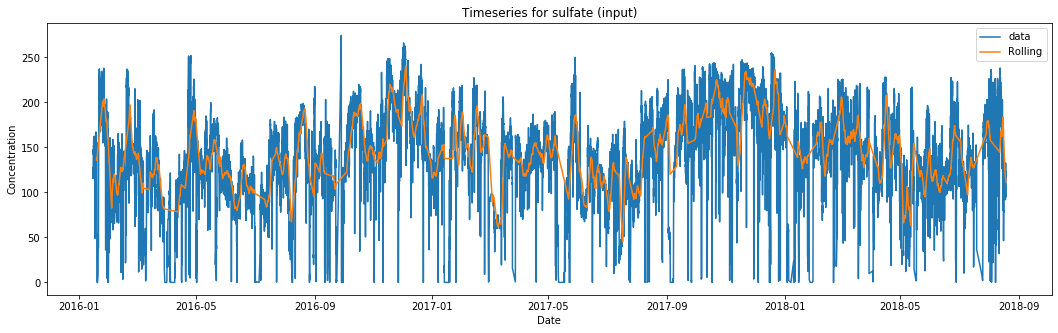

In [22]:
# Aggregating ceiled
rolling = df_full['primary_cleaner.input.sulfate'].rolling(90).mean()
date = df_full['date_ceiled']
rolling = pd.DataFrame({'rolling': rolling, 'date': date})

# set figure size
plt.figure( figsize = ( 18, 5))

# plot using rolling average
sns.lineplot( x = 'date_ceiled',
             y = 'primary_cleaner.input.sulfate',
             data = df_full,
             label = 'data')

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'date',
             y = 'rolling',
             data = rolling,
             label = 'Rolling')
  
plt.ylabel('Concentration')
plt.xlabel('Date')  
plt.title('Timeseries for sulfate (input)')
plt.show()

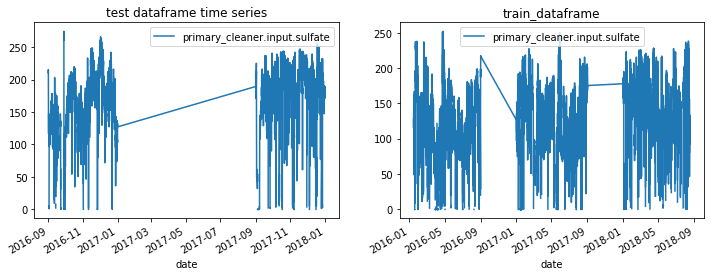

In [23]:
# Checking time Series in test and train dataframe
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax[0] = df_test[['date', 'primary_cleaner.input.sulfate']].plot(x='date', ax=ax[0]);
ax[1] = df_train[['date', 'primary_cleaner.input.sulfate']].plot(x='date', ax=ax[1]);
ax[0].set_title('test dataframe time series')
ax[1].set_title('train_dataframe')
plt.show()

> **Observations:**
> - it seems that train and test dataframe are just complementary slices of the full dataframe. -> Ceiling 
> - To make sure that the dataframe can be ceiled, the values of one random date out of the df have been compared

In [24]:
# Selecting a random date within the test set to compare values
test_tim = pd.Timestamp(2017, 12, 31, 22, 59, 59)
pd.concat((df_test[df_test['date']==test_tim], 
           df_full.loc[df_full['date']==test_tim, 
                       df_test[df_test['date']==test_tim].columns]))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5854,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.20034,1496.569047,...,19.95876,-499.95875,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.01266,-500.154284
17207,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.20034,1496.569047,...,19.95876,-499.95875,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.01266,-500.154284


> The date column has to be ceiled

In [25]:
# Ceiling date column
df_test['date'] = df_test['date'].dt.ceil('H')
df_test.head(2)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 01:00:00,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 02:00:00,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


### 1.3.3. Setting the time as index
> To ease further preprocessing and analytics of the dataframes, the datetime collumn has been set as index and all the additional date collumns have been removed from the dateframes

In [26]:
for df in (df_train, df_test):
    df.set_index('date', drop=True, inplace=True)
df_full.set_index('date_ceiled', drop=True, inplace=True)
df_full.drop('date', axis=1,inplace=True)

### 1.3.4. Filling missing / 0 values
> The strategy for dealing with 0 and NaN in this project, to fill them in the full dataset and map the results then to the related slice (test und train dataframe)  
> For the filling strategy the circumstance mentioned in the project description has been used: 
>> *Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.*  

In [27]:
targets = [col for col in df_full.columns if 'recovery' in col]
df_full[targets].isna().sum()

final.output.recovery      1963
rougher.output.recovery    3119
dtype: int64

In [28]:
cnt_one_missing = df_full[(df_full['rougher.output.recovery'].isna()==True) | \
                           (df_full['final.output.recovery'].isna()==True)].shape[0]
cnt_both_missing = df_full[(df_full['rougher.output.recovery'].isna()==True) & \
                           (df_full['final.output.recovery'].isna()==True)].shape[0]
total_rows = df_full.shape[0]

In [29]:
print('By dropping {} rows, {:.2%} of the Dataset will be dropped'.format(cnt_one_missing, cnt_one_missing/total_rows))
print('By dropping {} rows, {:.2%} of the Dataset will be dropped'.format(cnt_both_missing, cnt_both_missing/total_rows))

By dropping 3277 rows, 14.43% of the Dataset will be dropped
By dropping 1805 rows, 7.95% of the Dataset will be dropped


# 1.3.4.1. Dropping target NaNs
> Before filling the values, the datapoints which are missing both values for the target (in this case the recovery for rougher and output) will be dropped to avoid distortion of the results the model want to predict.  


In [30]:
mask_to_drop = df_full[(df_full['rougher.output.recovery'].isna()==True) | \
                           (df_full['final.output.recovery'].isna()==True)].index


In [31]:
mask_to_drop

DatetimeIndex(['2016-01-17 01:00:00', '2016-01-17 05:00:00',
               '2016-01-19 03:00:00', '2016-01-19 04:00:00',
               '2016-01-19 05:00:00', '2016-01-19 06:00:00',
               '2016-01-19 07:00:00', '2016-01-19 08:00:00',
               '2016-01-19 09:00:00', '2016-01-19 10:00:00',
               ...
               '2018-08-11 17:00:00', '2018-08-11 18:00:00',
               '2018-08-11 19:00:00', '2018-08-11 20:00:00',
               '2018-08-11 21:00:00', '2018-08-16 00:00:00',
               '2018-08-16 01:00:00', '2018-08-16 02:00:00',
               '2018-08-16 03:00:00', '2018-08-16 04:00:00'],
              dtype='datetime64[ns]', name='date_ceiled', length=3277, freq=None)

In [32]:
# Dropping from full dataframe
df_full.drop(mask_to_drop, axis=0, inplace=True)
#Drop values in test and train df
for df in (df_test, df_train):
    intersect = [idx for idx in mask_to_drop if idx in df.index]
    df.drop(intersect, axis=0, inplace=True)

In [33]:
targets = [col for col in df_full.columns if 'recovery' in col]
df_full[targets].isna().sum()

final.output.recovery      0
rougher.output.recovery    0
dtype: int64

#### 1.3.4.2. Filling features

> Thus, the NaN values will be filled in based on their neighbours:
> 1. forward fill - choosen in this project
> 2. With interpolation (linear)  - possible option, could be evaluated, if more accurate
> 3. In a later project filling the dataframe with square or qubic splines can be tested, if it brings more accurate results.

In [34]:
df_full_ffill = df_full.fillna(method='ffill')
df_test_ffill = df_test.fillna(method='ffill')
df_train_ffill = df_train.fillna(method='ffill')

# Check if filling was successfull
print(df_full_ffill.isna().sum().max())

0


> Sucessufull filled all NaN values

### 1.3.5. Adding targets to test dataset 
> Due to the fact, that the test dataset does not contain the targets (Recovery), they are added from the full dataframe  
> Therefore the indexes (Timerange) of the dataframes has been determined before the columns have been added

In [35]:
# Generate the index list of the intersection of two full and test dataframe
idx = df_test_ffill.index.intersection(df_full_ffill.index)
print (idx)

DatetimeIndex(['2016-09-01 01:00:00', '2016-09-01 02:00:00',
               '2016-09-01 03:00:00', '2016-09-01 04:00:00',
               '2016-09-01 05:00:00', '2016-09-01 06:00:00',
               '2016-09-01 07:00:00', '2016-09-01 08:00:00',
               '2016-09-01 09:00:00', '2016-09-01 10:00:00',
               ...
               '2017-12-31 15:00:00', '2017-12-31 16:00:00',
               '2017-12-31 17:00:00', '2017-12-31 18:00:00',
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00'],
              dtype='datetime64[ns]', length=5290, freq=None)


In [36]:
# Aggregating necessary columns
targets = [col for col in df_full_ffill.columns if 'recovery' in col]

# Adding tartgets to test df
df_test_ffill[targets] = df_full_ffill.loc[idx, targets]

> **Coclution for this step:**
> - In this step the date cllumn of all three dataframe has been ceiled to synchronize them
> - GThe date collumn has been set as index in order to be able to compare the 3 dataframes based on the dates
> - The missing values have been filled by using ffill as filling method
> - The targets have been added to the test dataframe

# 2. Analyzing the data





## 2.1. Metal concentration over purification stages
In this step the concentration of metals (Au, Ag, Pb) and its contentration changes depending on the purification stage has been investigated  
The purification stages are the primary and secondary cleaner which are fed with the concentrate from the floatation process.

In [37]:
# Aggregation of raw material
raw_cols = [col for col in df_full_ffill.columns if (
    ('rougher.input' in col) and (any(met in col for met in METALS)))]
raw_cols

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']

In [38]:
# Aggregation of flotation output
float_cols = [col for col in df_full_ffill.columns if (
    ('rougher.output' in col) and (any(met in col for met in METALS)))]
float_cols

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au']

In [39]:
# Aggregating collumns primary cleaner
primary_clean_cols = [col for col in df_full_ffill.columns if (
    ('primary' in col) and (any(met in col for met in METALS)))]
primary_clean_cols

['primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au']

In [40]:
# Aggregating columns secondary cleaner
s_clean_tails = [col for col in df_full_ffill.columns if (
    ('secondary_cleaner.output' in col) and (any(met in col for met in METALS)))]
s_clean_concs = [col for col in df_full_ffill.columns if (
    ('final.output.concentrate' in col) and (any(met in col for met in METALS)))]
s_clean_cols = s_clean_tails + s_clean_concs
s_clean_cols

['secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au']

In [41]:
# Calculating means of concentrations
raw_means = df_full_ffill.loc[:, raw_cols].mean()
float_means = df_full_ffill.loc[:, float_cols].mean()
primary_means = df_full_ffill.loc[:, primary_clean_cols].mean()
secondary_means = df_full_ffill.loc[:, s_clean_cols].mean()

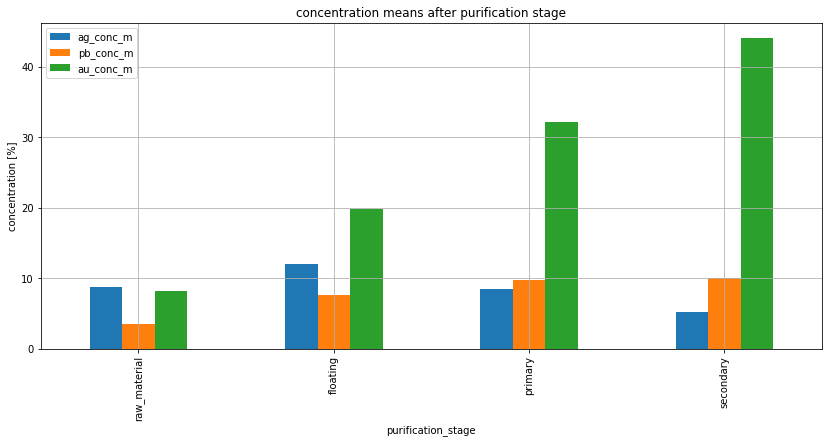

In [42]:
# Plotting how concentrates changed
concs = pd.DataFrame([raw_means.reset_index(drop=True),
                      float_means[0:3].reset_index(drop=True),
                      primary_means[0:3].reset_index(drop=True),
                      secondary_means[3:].reset_index(drop=True)
                     ], 
                     index=['raw_material', 'floating', 'primary', 'secondary'])
concs.columns =['ag_conc_m', 'pb_conc_m', 'au_conc_m']
concs.plot(kind='bar',
           grid=True,
           figsize=(14,6),
           title='concentration means after purification stage',
           ylabel='concentration [%]',
           xlabel='purification_stage'
          );

> **Observations:**
> Within the gold extracting process, the concentration in the concentrate for ag,pb and au changes as seen above:
> - AU increases constantly from step to step from total 8-40% (in middle)
> - PB increases constantly but only in a range from 3-8% (in middle)
> - AG increases in the floating process and decreases afterwards constantly 

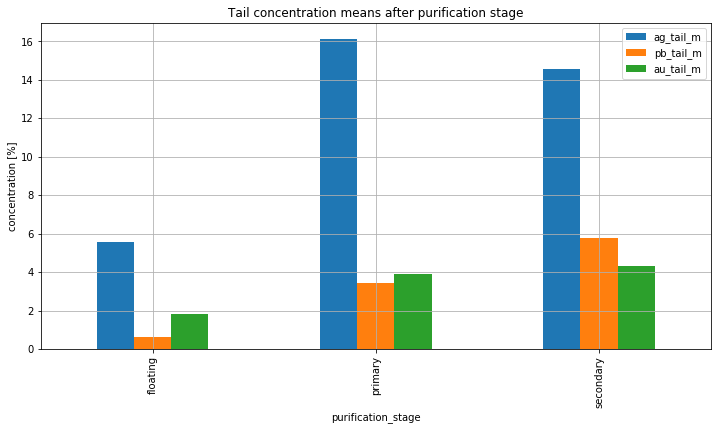

In [43]:
# Plotting how concentrates changed
concs = pd.DataFrame([float_means[3:].reset_index(drop=True),
                      primary_means[3:].reset_index(drop=True),
                      secondary_means[0:3].reset_index(drop=True)
                     ],
                     index=['floating', 'primary', 'secondary'])
concs.columns =['ag_tail_m', 'pb_tail_m', 'au_tail_m']
concs.plot(kind='bar',
           grid=True,
           figsize=(12,6),
           title='Tail concentration means after purification stage',
           ylabel='concentration [%]',
           xlabel='purification_stage'
          );

> **Observations:**
> - The Silver concentration in the tail is constantly the highest share of the three metals
> - The Silver concentration is the highest in the primary purification stage whereas the shares of pb and au are constantly growing over the stages  
> \-\> This means, that the share of gold in the concentrate increases over the purification stages 

## 2.2. Particle size distribution of test and train set
> In this step the distribution for the particle size has been investigated because different input sizes lead to inaccurate models

In [44]:
# sclicing the dataframes
test_psize = df_test_ffill['rougher.input.feed_size']
train_psize = df_train_ffill['rougher.input.feed_size']

In [45]:
pd.DataFrame([test_psize.describe(), train_psize.describe()],
             index=['feed_size_test', 'feed_size_train'])

,count,mean,std,min,25%,50%,75%,max
feed_size_test,5290.0,55.952754,19.080334,0.046369,43.906504,50.846843,62.451165,392.494040
feed_size_train,14149.0,60.239856,23.005310,9.659576,48.966751,55.269784,66.007526,484.967466


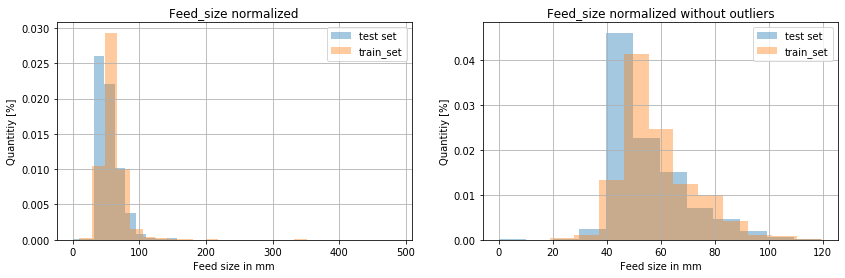

In [46]:
# plotting distributions
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
for df, name in zip((test_psize, train_psize), ('test set', 'train_set')):
    df.hist(density=True, alpha=0.4, bins=25, label=name, ax=ax[0])
    df.pipe(lambda x: x[x<120]).hist(density=True,
                                     alpha=0.4, 
                                     bins=12, 
                                     label=name, 
                                     ax=ax[1])

ax[0].set_xlabel('Feed size in mm') 
ax[0].legend()
ax[0].set_title('Feed_size normalized')
ax[0].set_ylabel('Quantitiy [%]')
ax[1].set_xlabel('Feed size in mm') 
ax[1].legend()
ax[1].set_title('Feed_size normalized without outliers')
ax[1].set_ylabel('Quantitiy [%]')
plt.show();

> **Observations:**
> - Both, train and test set have outliers
> - Distribution looks equal  
> \-\> No further actions needed

## 2.3. Substances through purification stages
> In this step the total concentrations of all substances at different stages has been investigated to find anomalies:
> - raw feed
> - rougher concentrate
> - primary cleaner concentrate
> - final concentrate.  


In [47]:
elements = METALS + ['sol']
# Aggregating rougher input
cols_rin_eles = [col for col in df_full_ffill.columns if (
    'rougher.input.feed' in col) and (any((el in col for el in elements)))]
# Aggregating primary cleaner concentrates
cols_pc_eles = [col for col in df_full_ffill.columns if (
    'primary_cleaner.output.concentrate' in col) and (any((el in col for el in elements)))]
# Aggregating cols rougher.output.concentrate
cols_rout_eles = [col for col in df_full_ffill.columns if 'rougher.output.con' in col]
# Aggregating final.output.concentrate
cols_fout_eles = [col for col in df_full_ffill.columns if 'final.output.con' in col]

raw_in = df_full_ffill.loc[:, cols_rin_eles]
raw_out = df_full_ffill.loc[:, cols_rout_eles]
pc_out = df_full_ffill.loc[:, cols_pc_eles]
final_out = df_full_ffill.loc[:, cols_fout_eles]

In [48]:
# barplots with 4bars x 3stages
# Calculating means of concentrations
raw_in_means = raw_in.mean()
raw_out_means = raw_out.mean()
pc_out_means = pc_out.mean()
final_out_means = final_out.mean()

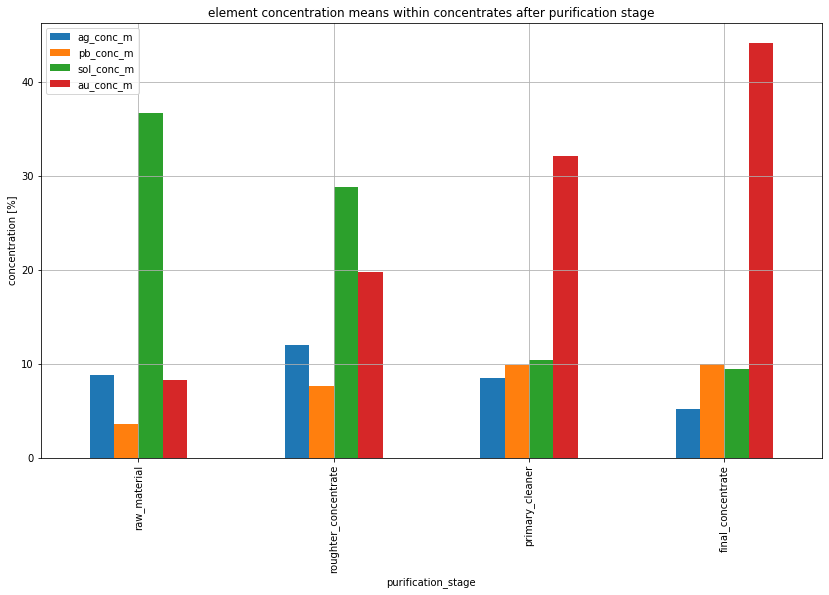

In [49]:
# Plotting how concentrates changed
concs = pd.DataFrame([raw_in_means.reset_index(drop=True),
                      raw_out_means.reset_index(drop=True),
                      pc_out_means.reset_index(drop=True),
                      final_out_means.reset_index(drop=True)
                     ], 
                     index=['raw_material', 'roughter_concentrate',
                            'primary_cleaner', 'final_concentrate'])
concs.columns =['ag_conc_m', 'pb_conc_m', 'sol_conc_m', 'au_conc_m']
concs.plot(kind='bar',
           grid=True,
           figsize=(14,8),
           title='element concentration means within concentrates after purification stage',
           ylabel='concentration [%]',
           xlabel='purification_stage'
          );

> The mean values are looking valid for the for elements over the purification stages

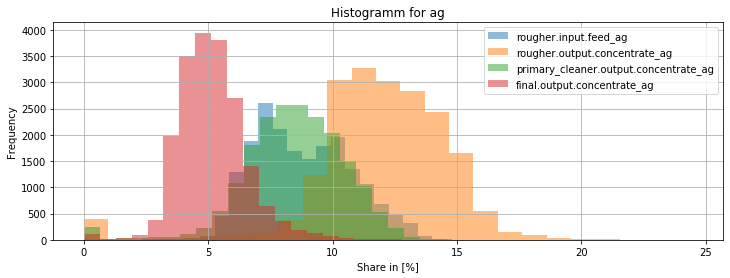

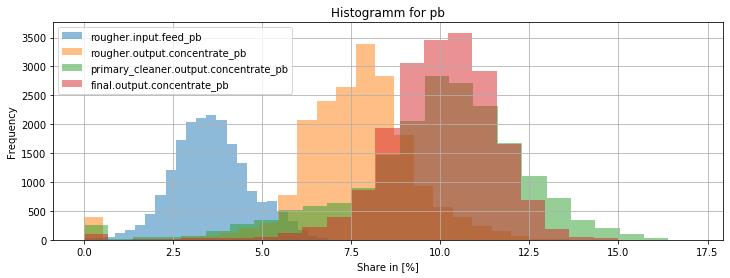

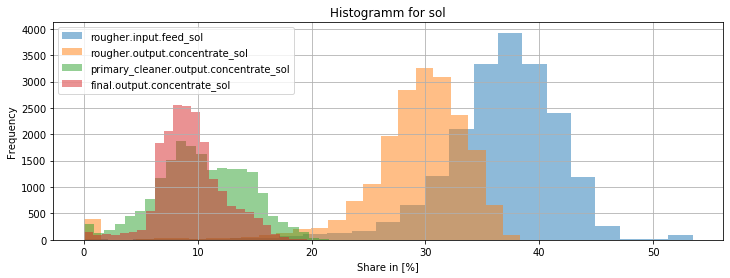

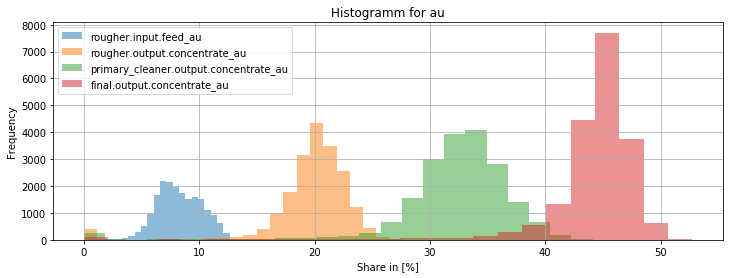

In [50]:
# Plotting histogramms for each element over purification stages
ele_ordered=['ag', 'pb', 'sol', 'au']
total_cols = cols_rin_eles + cols_rout_eles + cols_pc_eles + cols_fout_eles
for ele in ele_ordered:
    cols = [col for col in total_cols if ele in col]
    for col in cols:
        df_full_ffill[col].hist(bins=25, alpha=.5, label=col, figsize=(12,4))
    plt.ylabel('Frequency')
    plt.xlabel('Share in [%]')
    plt.legend()
    plt.title('Histogramm for' + ' ' + ele)
    plt.show();

> **Observations**
> - All of them have a peek around 0
> - Those entries should be removed because they seem to be faulty entries because an input without even a trace can not be true
> - Thus in the next step a threshold of .001 (0.1%) in the samples has been established for valid enties

In [51]:
# Create the mask (need to be removed from train and testset as well afterwards)
f_ag = .01
f_pb = .005
f_sol = .01
f_au = .01
mask_val = df_full_ffill[((df_full_ffill[cols_rin_eles[0]] < f_ag) == True) | \
                         ((df_full_ffill[cols_rin_eles[1]] < f_pb) == True) | \
                         ((df_full_ffill[cols_rin_eles[2]] < f_sol) == True) | \
                         ((df_full_ffill[cols_rin_eles[3]] < f_au) == True) | \
                         ((df_full_ffill[cols_rout_eles[0]] < f_ag) == True) | \
                         ((df_full_ffill[cols_rout_eles[1]] < f_pb) == True) | \
                         ((df_full_ffill[cols_rout_eles[2]] < f_sol) == True) | \
                         ((df_full_ffill[cols_rout_eles[3]] < f_au) == True) | \
                         ((df_full_ffill[cols_pc_eles[0]] < f_ag) == True) | \
                         ((df_full_ffill[cols_pc_eles[1]] < f_pb) == True) | \
                         ((df_full_ffill[cols_pc_eles[2]] < f_sol) == True) | \
                         ((df_full_ffill[cols_pc_eles[3]] < f_au) == True) | \
                         ((df_full_ffill[cols_fout_eles[0]] < f_ag) == True) | \
                         ((df_full_ffill[cols_fout_eles[1]] < f_pb) == True) | \
                         ((df_full_ffill[cols_fout_eles[2]] < f_sol) == True) | \
                         ((df_full_ffill[cols_fout_eles[3]] < f_au) == True)
                       ].index
print('Elements to drop: {}'.format(len(mask_val)))
df_full_ffill.drop(mask_val, axis=0, inplace=True)

Elements to drop: 725


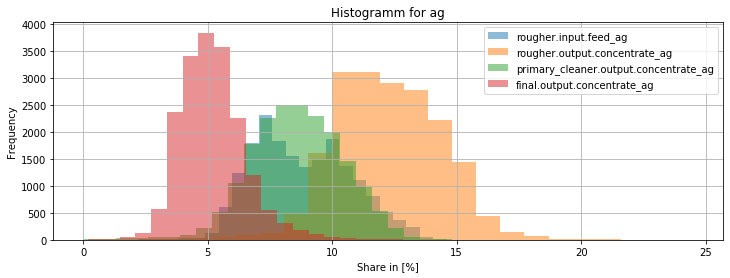

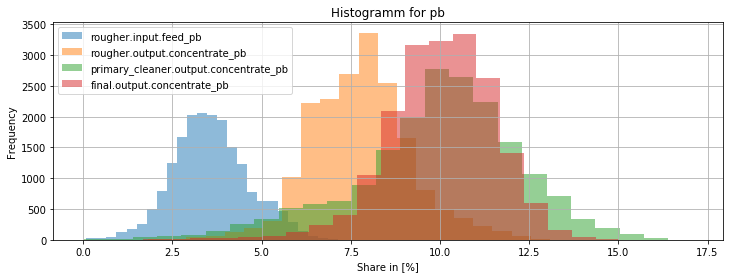

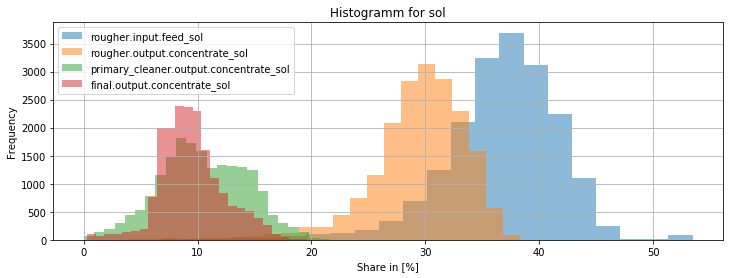

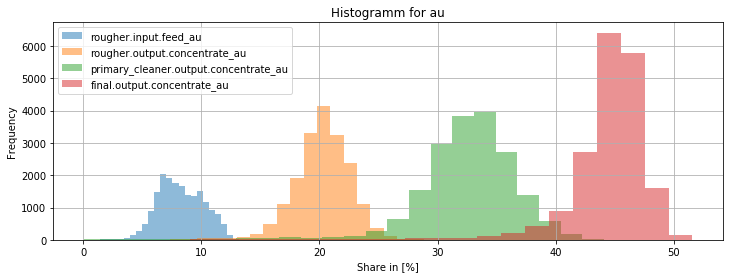

In [52]:
for ele in ele_ordered:
    cols = [col for col in total_cols if ele in col]
    for col in cols:
        df_full_ffill[col].hist(bins=25, alpha=.5, label=col, figsize=(12,4))
    plt.ylabel('Frequency')
    plt.xlabel('Share in [%]')
    plt.legend()
    plt.title('Histogramm for' + ' ' + ele)
    plt.show();

> **Observations:**
> - Suspicious peak is gone
> - Now the distibutions look kind of legit
> - Values need to be removed from test / train set as well
> - Around 16% of the data was invalid. A lot of those invalid datapoints resulted from the ffill

In [53]:
#Drop values in test and train df
for df in (df_test_ffill, df_train_ffill):
    intersect = [idx for idx in mask_val if idx in df.index]
    df.drop(intersect, axis=0, inplace=True)

# 3. Build the model
> In this step models have been built in order to predict the two recoveries to be able to calculate the final sMAPE

## 3.1. Write a function to calculate the final sMAPE value.
> In this step a custom evaluation function for this problem has been implemented.   
> THe evaluation metrics is calculated in 3 steps:
> 1. Calculating sMAPE for rougher recovery
> 2. Calculating sMAPE for porification recovery
> 3. Add the two sMAPES in a ratio of 3 / 1

> The single calculations for the sMAPE can be seen below.

In [54]:
Image(url= "https://pictures.s3.yandex.net/resources/smape_1576239058_1589899769.jpg", width=500)

In [55]:
Image(url= "https://pictures.s3.yandex.net/resources/_smape_1_1589900649.jpg", width=500)

In [56]:
def smape_loss_func(y, y_pred):
    '''Custom cost function which is calculating the smape for the inputs
    arguments: 
        y: targets [list, np.array or pandas.Series]
        y_pred: predictions [list, np.array or pandas.Series]
    returns:
        smape: [float]
    '''
    if len(y_pred) != len(y): raise ValueError('Please input arrays of same lenght')
    n = len(y_pred)
    nominator = abs(y - y_pred)
    denominator = (abs(y) + abs(y_pred)) / 2
    factor = (1 / n) * 100
    smape = factor * ((nominator / denominator).sum())
    return smape
    

# Create scorer for cross validation 
smape = make_scorer(smape_loss_func, greater_is_better=True)

## 3.2. Preparing the dataframe, slicing features and targets
> Due to the fact that the train df contains 32 more features than the test df, measures have to be taken.  
> This measures contained dropping the columns which are in train but not in testset because the assumption has been made that those values would not be available during production.  

> Due to the fact, that the project requires two predictions (rougher and cleaner recovery), two models had to be trained.  
> Those circumstances led to the fact, that the dataframe might  to be seperated for those two steps as well.  
> Futhermore the targets and features in the test and the train set have been sliced.   

### 3.2.1. Dropping features

In [57]:
# Aggregate collumns which are not in test but in train
cols_to_drop = [col for col in df_train_ffill.columns if col not in df_test_ffill.columns]
cols_to_drop
# Drop aggregated cols
df_train_ffill.drop(cols_to_drop, inplace=True, axis=1)

### 3.2.2. Seperating dataframe 

In [58]:
# Aggregating columns after purification step
cols_rougher = [col for col in df_train_ffill.columns if 'rougher' in col]
cols_cleaner = [col for col in df_train_ffill.columns if 'rougher' not in col]

In [59]:
# Slicing rougher dfs
df_train_rougher = df_train_ffill[cols_rougher]
df_test_rougher = df_test_ffill[cols_rougher]

# Sclicing cleaner dfs
df_train_cleaner = df_train_ffill[cols_cleaner]
df_test_cleaner = df_test_ffill[cols_cleaner]

### 3.2.3. Train and Test split for dataframes
> In this step the dataframes have been split to check if it makes sense to train the models only on the features of their current process or the whole featureset

#### 3.2.3.1. With seperated dataframes

In [60]:
# Defining targets
target_rougher = 'rougher.output.recovery'
target_cleaner = 'final.output.recovery'

# Splitting targets and features
# Rougher
X_train_rs = df_train_rougher.drop(target_rougher, axis=1)
y_train_rs = df_train_rougher[target_rougher]

X_test_rs = df_test_rougher.drop(target_rougher, axis=1)
y_test_rs = df_test_rougher[target_rougher]

# Flotation
X_train_cs = df_train_cleaner.drop(target_cleaner, axis=1)
y_train_cs = df_train_cleaner[target_cleaner]

X_test_cs = df_test_cleaner.drop(target_cleaner, axis=1)
y_test_cs = df_test_cleaner[target_cleaner]

#### 3.2.3.2. With one dataframe

In [61]:
# Defining targets
target_rougher = 'rougher.output.recovery'
target_cleaner = 'final.output.recovery'

# Splitting targets and features
# Rougher
X_train_rcomb = df_train_ffill.drop(target_rougher, axis=1)
y_train_rcomb = df_train_ffill[target_rougher]

X_test_rcomb = df_test_ffill.drop(target_rougher, axis=1)
y_test_rcomb = df_test_ffill[target_rougher]

# Flotation
X_train_ccomb = df_train_ffill.drop(target_cleaner, axis=1)
y_train_ccomb = df_train_ffill[target_cleaner]

X_test_ccomb = df_test_ffill.drop(target_cleaner, axis=1)
y_test_ccomb = df_test_ffill[target_cleaner]

## 3.3. Train different models 

> The function below are used within the evaluation process to find the best fitting algorithm and hyperparameter set

In [62]:
def print_header():
    '''Helper function. Prinds head for analysis'''
    print('%-11s | %-10s | %-5s' %
              ('Regressor',  'Mean smape', 'STD'))
    print('-'*35)

In [63]:
def display_results(results, names):
    '''Helper function. Prints results'''
    print_header()    
    for name, result in zip(names, results):
        msg = '%-10s: | %-10f | %f' % (name, result.mean(), result.std())
        print(msg)

In [64]:
def create_pipe():
    pipe = []
    pipe.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
    pipe.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
    pipe.append(('ScaledRFR', Pipeline([('Scaler', StandardScaler()),
                                        ('RFR', RandomForestRegressor(random_state=RANDOM_STATE))])))
    pipe.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),
                                        ('GBM', GradientBoostingRegressor(random_state=RANDOM_STATE))])))
    pipe.append(('Dummy', Pipeline([('Scaler', StandardScaler()), ('Dummy', DummyRegressor())])))
    return pipe

In [65]:
def cv_piped_models(pipe, X_train, y_train):
    results = []
    names = []
    for name, model in pipe:
        kfold = KFold(n_splits=10, random_state=RANDOM_STATE)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=smape)
        results.append(cv_results)
        names.append(name)
    return(results, names)

### 3.3.1. Model evaluation rougher
> In this step the Machine Learning algorithm for the rougher process has been investigated with standard scaled data (brings better results, was tested) to select a ML algorithm for further improvement

#### 3.3.1.1. Separated dataframes

In [66]:
# Aggregating different models for sequential cv
pipe_rs = create_pipe()
results_rs, names_rs = cv_piped_models(pipe_rs, X_train_rs, y_train_rs)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [67]:
display_results(results_rs, names_rs)

Regressor   | Mean smape | STD  
-----------------------------------
ScaledLR  : | 6.023508   | 1.371422
ScaledKNN : | 7.903813   | 2.798808
ScaledRFR : | 6.979666   | 1.838740
ScaledGBM : | 6.315725   | 1.866243
Dummy     : | 7.684446   | 2.244995


>  **Observations:**
> - Linear regression seems to be by far the best fitting one for this problem. It shows the lowest sMAPE and the lowest variance, which means that it is the most robust to different input  
> - KNN performs worse than a dummy regressor which predicts mean all the time, so should not be used for this project

#### 3.3.1.2. Combined dataframe

In [68]:
pipe_rcomb = create_pipe()
results_rcomb, names_rcomb = cv_piped_models(pipe_rcomb, X_train_rcomb, y_train_rcomb)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
display_results(results_rcomb, names_rcomb)

Regressor   | Mean smape | STD  
-----------------------------------
ScaledLR  : | 5.258767   | 0.929095
ScaledKNN : | 6.828586   | 1.625412
ScaledRFR : | 5.349528   | 1.171809
ScaledGBM : | 5.006077   | 1.069217
Dummy     : | 7.684446   | 2.244995


> **Observations:**
> - The model trained with the complete set of features shows overall better results. In this setup all models are far better than the Dummy regressor whereas KNN still is the worsed regressor and should not be used for this problem
> - Gradiend boosting (GBM) seems to work better with the full dataset than linear regression 

### 3.3.2 Model evaluation cleaner
> In this step the Machine Learning algorithm for the cleaner process has been investigated with standard scaled data (brings better results, was tested) 

#### 3.3.2.1. Separated dataframes

In [70]:
pipe_cs = create_pipe()
results_cs, names_cs = cv_piped_models(pipe_cs, X_train_cs, y_train_cs)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [71]:
display_results(results_cs, names_cs)

Regressor   | Mean smape | STD  
-----------------------------------
ScaledLR  : | 9.535955   | 1.045550
ScaledKNN : | 10.811449  | 1.250978
ScaledRFR : | 10.764878  | 1.305254
ScaledGBM : | 9.674884   | 1.073818
Dummy     : | 10.320850  | 1.384159


#### 3.3.2.2.. Combined dataframes

In [72]:
pipe_ccomb = create_pipe()
results_ccomb, names_ccomb = cv_piped_models(pipe_ccomb, X_train_ccomb, y_train_ccomb)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [73]:
display_results(results_ccomb, names_ccomb)

Regressor   | Mean smape | STD  
-----------------------------------
ScaledLR  : | 8.313473   | 1.160248
ScaledKNN : | 10.095536  | 1.447356
ScaledRFR : | 8.564364   | 0.923768
ScaledGBM : | 7.663240   | 0.937938
Dummy     : | 10.320850  | 1.384159


> **Observations:**
> - The sMAPEs of the second stage are much higher than the smapes of the first stage
> - The model trained with the complete set of features shows better results
> - Gradient boost regressor seems to be by far the best fitting one for this problem. It shows the lowest sMAPE and more or less the same variance than the Random forest regressor. This means means that it is the most robust to different inputs. 

## 3.4. Final evaluation

In [74]:
def print_header_eval():
    '''Helper function. Prinds head for analysis'''
    print('%-11s | %-10s' % ('Regressor',  'Smape'))
    print('-'*35)
def display_results_eval(results, names):
    '''Helper function. Prints results'''
    print_header_eval()    
    for name, result in zip(names, results):
        msg = '%-10s: | %-10f' % (name, result.mean())
        print(msg)

In [75]:
def valid_piped_models(pipe, X_test, X_train, y_test, y_train):
    results = []
    names = []
    for name, model in pipe:
        model.fit(X_train, y_train)
        smape_ = smape(model, X_test, y_test)
        results.append(smape_)
        names.append(name)
    return(results, names)

### 3.4.1. Rougher


In [76]:
# Testing performance on combined dataframe
valid_r_comb = create_pipe()
display_results_eval(*valid_piped_models(
    valid_r_comb, X_test_rcomb, X_train_rcomb, y_test_rcomb, y_train_rcomb))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Regressor   | Smape     
-----------------------------------
ScaledLR  : | 116.633028
ScaledKNN : | 5.110400  
ScaledRFR : | 5.122707  
ScaledGBM : | 43.140887 
Dummy     : | 5.355039  


> **Observation:**
> - Linear regression and Gradient boosting turn out to be pretty bad. Also Knn and Random forests are only slightly better than the dummy model.
> - This needs investigation

In [77]:
# Train Linreg for rougher
pipe_r = Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])
pipe_r.fit(X_train_rcomb, y_train_rcomb)
pipe_r.predict(X_test_rcomb)

array([434.8007413 , 420.10473766, 423.25876934, ..., 732.32521801,
       742.68799552, 752.99996275])

> Those concentrations are not valid. This is most likely the case because the entirely feature set is used for the prediction from the rougher process. Thus some data of the purification process might influence the model accuracy  
> To test that theory, the featureset of the rougher process only will be tested in the next step

In [78]:
# Testing performance on seperated dataframe
valid_r_sep = create_pipe()
display_results_eval(*valid_piped_models(
    valid_r_sep, X_test_rs, X_train_rs, y_test_rs, y_train_rs))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Regressor   | Smape     
-----------------------------------
ScaledLR  : | 4.538030  
ScaledKNN : | 4.890433  
ScaledRFR : | 4.817828  
ScaledGBM : | 3.919166  
Dummy     : | 5.355039  


> **Observations:**
> - The Reason for the invalid predictions was the use of the whole featureset.  
> - All regressors are now way better than the dummy regressor
> - Scaled Gradied boosting seems to be the regressor to go for this project. Its hyperparameters will be tuned later on to increase its accuracy

### 3.4.2. Flotation

In [79]:
# Testing performance on combined dataframe
valid_f_ccomb = create_pipe()
display_results_eval(*valid_piped_models(
    valid_f_ccomb, X_test_ccomb, X_train_ccomb, y_test_ccomb, y_train_ccomb))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Regressor   | Smape     
-----------------------------------
ScaledLR  : | 149.786551
ScaledKNN : | 17.299184 
ScaledRFR : | 10.644546 
ScaledGBM : | 8.747459  
Dummy     : | 8.576008  


> All regressors are worse than the dummy regressor by using the complete dataset  
> -> Thus the dataset with the limited featureset will be tested

In [80]:
# Testing performance on combined dataframe
valid_f_cs = create_pipe()
display_results_eval(*valid_piped_models(
    valid_f_cs, X_test_cs, X_train_cs, y_test_cs, y_train_cs))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Regressor   | Smape     
-----------------------------------
ScaledLR  : | 8.170717  
ScaledKNN : | 11.119314 
ScaledRFR : | 12.810564 
ScaledGBM : | 9.356001  
Dummy     : | 8.576008  


> **Observations:**
> - The mean here is with 8.57 (outcome dummy) much lower than the mean of the test set during cross validation 10.32. (dummy regressor)  
> This might be a reason for the bad results, that the test and train set differ drastically
> - The linear regressor of the linear model seems to have the best outcome and is the only one better than the dummy regressor.   
> \-\> Due to the fact, that it was the second best solution for the cross validation this will be choosen for the purification stage

### 3.5 hyperparameter tuning gradiend boost rougher

In [81]:
# Creating pipeline with scaler and gradient boost regressor
pipe_r_tun = Pipeline([('Scaler', StandardScaler()),
                       ('GBM', GradientBoostingRegressor(random_state=RANDOM_STATE))])

# Assembling param Grid for randomized grid serach
param_grid = {
    'GBM__n_estimators': [50, 100, 150],
    'GBM__max_depth': [5,10,15],
    'GBM__min_samples_leaf': [1,3,5],
    'GBM__min_samples_split': [2,5,8]
}
rand_search = RandomizedSearchCV(
    estimator = pipe_r_tun,
    param_distributions=param_grid, 
    n_iter=50,
    scoring=smape,
    cv=5,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)
retrain = 1
if retrain:
    rand_search.fit(X_train_rs, y_train_rs);
else:
    rand_search = joblib.load('.\Gradient_boost_search.joblib')

In [82]:
rand_search.best_score_

7.241683591563642

In [83]:
# Creating pipeline with scaler and gradient boost regressor
pipe_r_tun_1 = Pipeline([('Scaler', StandardScaler()),
                       ('GBM', GradientBoostingRegressor(random_state=RANDOM_STATE))])

# Assembling param Grid for randomized grid serach
param_grid_1 = {
    'GBM__n_estimators': list(int(e) for e in np.linspace(40,100,21)),
    'GBM__max_depth': list(range(1,13)),
    'GBM__min_samples_leaf': [1,3,5],
    'GBM__min_samples_split': [2,5,8]
}
rand_search_1 = RandomizedSearchCV(
    estimator = pipe_r_tun_1,
    param_distributions=param_grid_1, 
    n_iter=50,
    scoring=smape,
    cv=5,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)
retrain = 1
if retrain:
    rand_search_1.fit(X_train_rs, y_train_rs);
else:
    rand_search_1 = joblib.load('.\Gradient_boosting_search_1.joblib')

In [84]:
rand_search_1.best_params_

{'GBM__n_estimators': 58,
 'GBM__min_samples_split': 8,
 'GBM__min_samples_leaf': 5,
 'GBM__max_depth': 10}

In [85]:
rand_search_1.best_score_

6.9280656889632475

In [86]:
test = Pipeline([('Scaler', StandardScaler()), ('GBR',GradientBoostingRegressor(
    n_estimators = 58,
    min_samples_split = 8,
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=RANDOM_STATE))])
test.fit(X_train_rs, y_train_rs)
smape(test, X_test_rs, y_test_rs)

4.26335553794338

> We did not find a propper model with the random grid search. Thus now some options are tried out manually:  
> **Investigating depth, will be tested from 1-10**

In [87]:
# Splitting train in test and valid set to prevent overfitting
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_rs, y_train_rs, test_size=0.4, random_state=RANDOM_STATE)

In [88]:
# Train Linreg for rougher
for depth in range(1,11):
    pipe_man = Pipeline([('Scaler', StandardScaler()),
                          ('LR', GradientBoostingRegressor(random_state=RANDOM_STATE, max_depth=depth))])
    pipe_man.fit(X_train, y_train)
    pred = pipe_man.predict(X_valid)
    smape_ = smape_loss_func(y=y_valid, y_pred=pred)
    print('depth: {}, smape_valid: {:5f}'.format(depth, smape_))

depth: 1, smape_valid: 4.756940
depth: 2, smape_valid: 4.238662
depth: 3, smape_valid: 3.850249
depth: 4, smape_valid: 3.521341
depth: 5, smape_valid: 3.322711
depth: 6, smape_valid: 3.103963
depth: 7, smape_valid: 2.989923
depth: 8, smape_valid: 2.910212
depth: 9, smape_valid: 2.900916
depth: 10, smape_valid: 2.904478


In [89]:
# Vaidate with testset 
pipe_man = Pipeline([('Scaler', StandardScaler()),
                      ('LR', GradientBoostingRegressor(random_state=RANDOM_STATE, max_depth=10))])
pipe_man.fit(X_train, y_train)
pred = pipe_man.predict(X_test_rs)
smape_ = smape_loss_func(y=y_test_rs, y_pred=pred)
smape_

4.55753306037037

> It seems that splitting the trainset for manual hyperparameter tuning is too small so that the theoretical improvements are not appying for the test set

> **Observations:**
> - The standard Gradiend boost regressor seems to be the best fitting for this problem

### 3.6. Combined


In [90]:
# Getting scores
valid_r_sep = create_pipe()
scores_rougher, _ = valid_piped_models(
    valid_r_sep, X_test_rs, X_train_rs, y_test_rs, y_train_rs)

valid_f_cs = create_pipe()
scores_cleaner, _ = valid_piped_models(
    valid_f_cs, X_test_cs, X_train_cs, y_test_cs, y_train_cs)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [91]:
smape_total = .25 * min(scores_rougher) + .75 * min(scores_cleaner)
print('Total sMAPE:', smape_total)

Total sMAPE: 7.107829245051651


# 4. Conclusion
> Within this project the following steps have been carried out:
> - Data preprocessing including filling missing values, removing invalid datapoints, adjusting the date and setting it as index
> - Crosvalidation for two models, one for each step
> - Training and evaluation of the models as well as calculation of the final sMAPE

> The final models have an combined sMAPE of 7.1, which is high but acceprable For fututer improvements the filling approaches could be changed, further features could be measured or more datapoints could be used.  
> The smape for the floatation process is much better thatn the one for the cleaning process. Maybe furter parameters which are availabe for the floatation process but not for the cleaning processes can be measured and implemented there in order to get a better result.